In [ ]:
import pandas as pd
# Load the dataset
df = pd.read_csv('/content/creditcard.csv')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 284807 entries, 0 to 284806
Data columns (total 31 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   Time    284807 non-null  float64
 1   V1      284807 non-null  float64
 2   V2      284807 non-null  float64
 3   V3      284807 non-null  float64
 4   V4      284807 non-null  float64
 5   V5      284807 non-null  float64
 6   V6      284807 non-null  float64
 7   V7      284807 non-null  float64
 8   V8      284807 non-null  float64
 9   V9      284807 non-null  float64
 10  V10     284807 non-null  float64
 11  V11     284807 non-null  float64
 12  V12     284807 non-null  float64
 13  V13     284807 non-null  float64
 14  V14     284807 non-null  float64
 15  V15     284807 non-null  float64
 16  V16     284807 non-null  float64
 17  V17     284807 non-null  float64
 18  V18     284807 non-null  float64
 19  V19     284807 non-null  float64
 20  V20     284807 non-null  float64
 21  V21     28

In [ ]:
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
df['Amount']=sc.fit_transform(pd.DataFrame(df['Amount']))

In [ ]:
df = df.drop(['Time'],axis=1)  # drop Time (not useful for prediction)

In [ ]:
df.duplicated().any()

np.True_

In [ ]:
df = df.drop_duplicates()

In [ ]:
df.shape

(275663, 30)

In [ ]:
df['Class'].value_counts()

,count
Class,
0,275190
1,473


In [ ]:
import numpy as np
import pandas as pd

# 1. Extract fraudulent transactions
fraud_df = df[df['Class'] == 1]
fraud_features = fraud_df.drop('Class', axis=1)

# 2. Get mean and std of each feature
feature_stats = fraud_features.describe().T[['mean', 'std']]

# 3. Decide how many synthetic samples you need
n_real_fraud = len(fraud_df)
n_total = len(df)
n_nonfraud = len(df[df['Class'] == 0])
n_synthetic_needed = n_nonfraud - n_real_fraud

print(f"Generating {n_synthetic_needed} synthetic fraud samples...")

# 4. Generate synthetic samples
synthetic_data = np.zeros((n_synthetic_needed, fraud_features.shape[1]))

np.random.seed(42)  # for reproducibility

for i, col in enumerate(fraud_features.columns):
    mean = feature_stats.loc[col, 'mean']
    std = feature_stats.loc[col, 'std']
    synthetic_data[:, i] = np.random.normal(loc=mean, scale=std, size=n_synthetic_needed)

# 5. Create a DataFrame and add the Class column
synthetic_df = pd.DataFrame(synthetic_data, columns=fraud_features.columns)
synthetic_df['Class'] = 1  # label as fraud

# 6. Concatenate with original dataset
balanced_df = pd.concat([df, synthetic_df], ignore_index=True)

# 7. Shuffle the final dataset
balanced_df = balanced_df.sample(frac=1, random_state=42).reset_index(drop=True)

print("✅ Synthetic fraud data generated and dataset is now balanced.")
print("Final class distribution:\n", balanced_df['Class'].value_counts())


Generating 274717 synthetic fraud samples...
✅ Synthetic fraud data generated and dataset is now balanced.
Final class distribution:
 Class
1    275190
0    275190
Name: count, dtype: int64


Confusion Matrix:
[[55011    27]
 [   97 54941]]

Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     55038
           1       1.00      1.00      1.00     55038

    accuracy                           1.00    110076
   macro avg       1.00      1.00      1.00    110076
weighted avg       1.00      1.00      1.00    110076

ROC-AUC Score: 0.9997


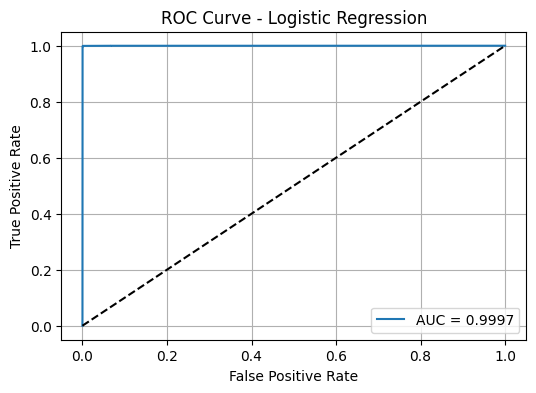

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve
import matplotlib.pyplot as plt
import seaborn as sns

# 1. Split features and target
X = balanced_df.drop('Class', axis=1)
y = balanced_df['Class']

# 2. Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# 3. Train Logistic Regression model
model = LogisticRegression(max_iter=1000, class_weight='balanced', random_state=42)
model.fit(X_train, y_train)

# 4. Make predictions
y_pred = model.predict(X_test)
y_prob = model.predict_proba(X_test)[:, 1]  # for ROC-AUC

# 5. Evaluation
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))

print("\nClassification Report:")
print(classification_report(y_test, y_pred))

print(f"ROC-AUC Score: {roc_auc_score(y_test, y_prob):.4f}")

# Plot ROC Curve
fpr, tpr, _ = roc_curve(y_test, y_prob)
plt.figure(figsize=(6, 4))
plt.plot(fpr, tpr, label=f'AUC = {roc_auc_score(y_test, y_prob):.4f}')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve - Logistic Regression")
plt.legend()
plt.grid(True)
plt.show()


Confusion Matrix:
[[55016    22]
 [   15 55023]]

Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     55038
           1       1.00      1.00      1.00     55038

    accuracy                           1.00    110076
   macro avg       1.00      1.00      1.00    110076
weighted avg       1.00      1.00      1.00    110076

ROC-AUC Score: 0.9999


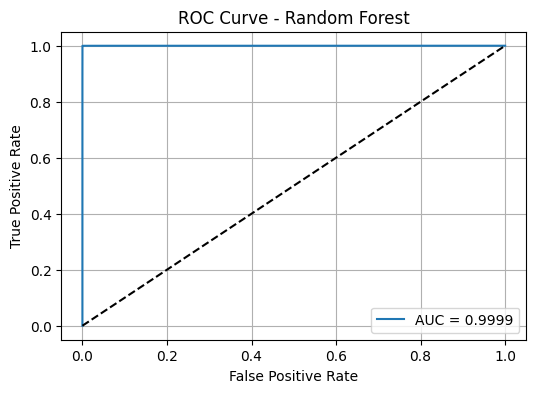

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve
import matplotlib.pyplot as plt
import seaborn as sns

# 1. Split features and target
X = balanced_df.drop('Class', axis=1)
y = balanced_df['Class']

# 2. Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# 3. Train Random Forest model
rf_model = RandomForestClassifier(
    n_estimators=100,
    class_weight='balanced',
    random_state=42,
    n_jobs=-1
)
rf_model.fit(X_train, y_train)

# 4. Make predictions
y_pred_rf = rf_model.predict(X_test)
y_prob_rf = rf_model.predict_proba(X_test)[:, 1]

# 5. Evaluation
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred_rf))

print("\nClassification Report:")
print(classification_report(y_test, y_pred_rf))

print(f"ROC-AUC Score: {roc_auc_score(y_test, y_prob_rf):.4f}")

# Plot ROC Curve
fpr_rf, tpr_rf, _ = roc_curve(y_test, y_prob_rf)
plt.figure(figsize=(6, 4))
plt.plot(fpr_rf, tpr_rf, label=f'AUC = {roc_auc_score(y_test, y_prob_rf):.4f}')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve - Random Forest")
plt.legend()
plt.grid(True)
plt.show()


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [11:13:32] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Confusion Matrix:
[[55023    15]
 [   20 55018]]

Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     55038
           1       1.00      1.00      1.00     55038

    accuracy                           1.00    110076
   macro avg       1.00      1.00      1.00    110076
weighted avg       1.00      1.00      1.00    110076

ROC-AUC Score: 1.0000


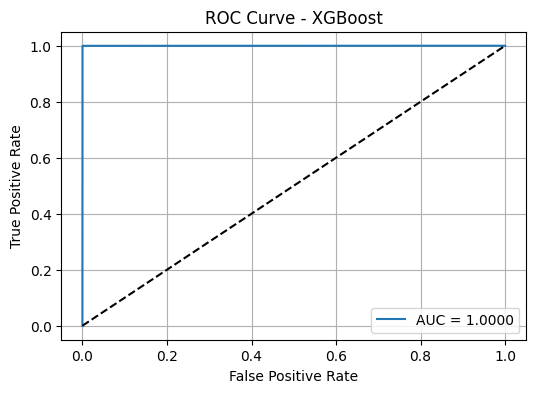

In [ ]:
from xgboost import XGBClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve
import matplotlib.pyplot as plt
import seaborn as sns

# 1. Split features and target
X = balanced_df.drop('Class', axis=1)
y = balanced_df['Class']

# 2. Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# 3. Train XGBoost model
xgb_model = XGBClassifier(
    objective='binary:logistic',
    eval_metric='logloss',
    use_label_encoder=False,
    scale_pos_weight=1,  # dataset is already balanced
    random_state=42,
    n_jobs=-1
)

xgb_model.fit(X_train, y_train)

# 4. Make predictions
y_pred_xgb = xgb_model.predict(X_test)
y_prob_xgb = xgb_model.predict_proba(X_test)[:, 1]

# 5. Evaluation
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred_xgb))

print("\nClassification Report:")
print(classification_report(y_test, y_pred_xgb))

print(f"ROC-AUC Score: {roc_auc_score(y_test, y_prob_xgb):.4f}")

# Plot ROC Curve
fpr_xgb, tpr_xgb, _ = roc_curve(y_test, y_prob_xgb)
plt.figure(figsize=(6, 4))
plt.plot(fpr_xgb, tpr_xgb, label=f'AUC = {roc_auc_score(y_test, y_prob_xgb):.4f}')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve - XGBoost")
plt.legend()
plt.grid(True)
plt.show()


In [ ]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score

accuracy_lr = accuracy_score(y_test, y_pred)
precision_score_lr = precision_score(y_test,y_pred)
recall_score_lr = recall_score(y_test,y_pred)
f1_score_lr = f1_score(y_test,y_pred)
print(f"Logistic Regression Accuracy: {accuracy_lr:.4f}")
print(f"Logistic Regression Precision Score: {precision_score_lr:.4f}")
print(f"Logistic Regression Recall Score: {recall_score_lr:.4f}")
print(f"Logistic Regression f1 Score: {f1_score_lr:.4f}")

print("-----------------------------------")

accuracy_rf = accuracy_score(y_test, y_pred_rf)
precision_score_rf = precision_score(y_test,y_pred_rf)
recall_score_rf = recall_score(y_test,y_pred_rf)
f1_score_rf = f1_score(y_test,y_pred_rf)
print(f"Random Forest Accuracy: {accuracy_rf:.4f}")
print(f"Random Forest Precision Score: {precision_score_rf:.4f}")
print(f"Random Forest Recall Score: {recall_score_rf:.4f}")
print(f"Random Forest f1 Score: {f1_score_rf:.4f}")

print("-----------------------------------")

accuracy_xgb = accuracy_score(y_test, y_pred_xgb)
precision_score_xgb = precision_score(y_test,y_pred_xgb)
recall_score_xbg = recall_score(y_test,y_pred_xgb)
f1_score_xbg = f1_score(y_test,y_pred_xgb)
print(f"XGBoost Accuracy: {accuracy_xgb:.4f}")
print(f"XGBoost Precision Score: {precision_score_xgb:.4f}")
print(f"XGBoost Recall Score: {recall_score_xbg:.4f}")
print(f"XGBoost f1 Score: {f1_score_xbg:.4f}")

Logistic Regression Accuracy: 0.9989
Logistic Regression Precision Score: 0.9995
Logistic Regression Recall Score: 0.9982
Logistic Regression f1 Score: 0.9989
-----------------------------------
Random Forest Accuracy: 0.9997
Random Forest Precision Score: 0.9996
Random Forest Recall Score: 0.9997
Random Forest f1 Score: 0.9997
-----------------------------------
XGBoost Accuracy: 0.9997
XGBoost Precision Score: 0.9997
XGBoost Recall Score: 0.9996
XGBoost f1 Score: 0.9997
